In [1]:
try:
    from dm_control import suite
    env = suite.load('humanoid', 'run')
    pixels = env.physics.render()
except Exception as e:
    raise e from RuntimeError(
    'Installition was wrong'
    )
else:
    from IPython.display import clear_output
    clear_output()
    del suite, env, pixels

In [2]:
# Imports

from dm_control import mujoco

In [3]:
# access to enums and mujoco library functions

from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

In [4]:
# PyMJCF

from dm_control import mjcf

In [5]:
# Composer high level imports

from dm_control import composer
from dm_control.composer.observation import observable
from dm_control.composer import variation

In [6]:
# imports for composer tutorial example

from dm_control.composer.variation import distributions
from dm_control.composer.variation import noises
from dm_control.locomotion.arenas import floors

In [7]:
# control suite

from dm_control import suite

In [8]:
# Run through corridor example

from dm_control.locomotion.walkers import cmu_humanoid
from dm_control.locomotion.arenas import corridors as corridor_arenas
from dm_control.locomotion.tasks import corridors as corridor_tasks

In [9]:
# Soccer
from dm_control.locomotion import soccer

In [10]:
# manipulation
from dm_control import manipulation

In [11]:
# other imports and helper functions
# general

import copy
import os
from IPython.display import clear_output
import numpy as np

In [12]:
# graphics-related
import matplotlib 
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image

# using svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

In [13]:
# font sizes

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE) # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE) # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE) # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title

In [14]:
# inline video helper function
if os.environ.get('COLAB_NOTEBOOK_TEST', False):
    # skip video generation during tests, as it is quite expensive
    display_video = lambda *args, **kwarghs: None
else:
    def display_video(frames, framerate=30):
        height, width, _ = frames[0].shape
        dpi = 70
        orig_backend = matplotlib.get_backend()
        matplotlib.use('Agg')  # switch to headless 'Agg' to prevent figure rendering
        fig, ax = plt.subplots(1, 1, figsize=(width/dpi, height/dpi), dpi=dpi)
        matplotlib.use(orig_backend)
        ax.set_axis_off()
        ax.set_aspect('equal')
        ax.set_position([0, 0, 1, 1])
        im = ax.imshow(frames[0])
        
        def update(frame):
            im.set_data(frame)
            return [im]
        
        interval = 1000 / framerate
        anim = animation.FuncAnimation(fig=fig, func=update, frames=frames, 
                                      interval=interval, blit=True, repeat=False)
        return HTML(anim.to_html5_video())
    
np.random.seed()
        

In [15]:
# model definition, compilition and rendering

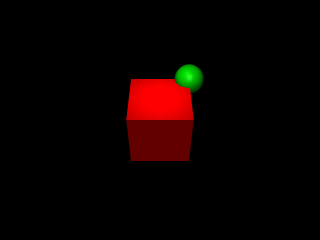

In [16]:
# simple model with two geoms and a light

static_model = """
<mujoco>
    <worldbody>
        <light name="top" pos="0 0 1" />
        <geom name = "red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
        <geom name = "green_sphere" pos=".2 .2 .2" size=".1" rgba = "0 1 0 1"/>
    </worldbody>
</mujoco>
"""

physics = mujoco.Physics.from_xml_string(static_model)
pixels = physics.render()
PIL.Image.fromarray(pixels)

In [17]:
# adding DOFs(degrees of freedom) by adding joints (hinge joint) to body and simulating


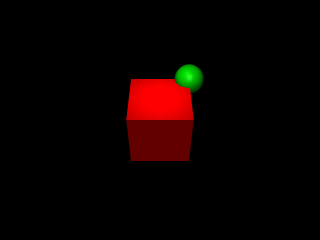

In [18]:
swinging_body = """
<mujoco>
    <worldbody>
        <light name="top" pos="0 0 1"/>
        <body name="box_and_sphere" euler="0 0 -30">
            <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2" />
            <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
            <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1" />
        </body>
    </worldbody>
</mujoco>
"""

physics = mujoco.Physics.from_xml_string(swinging_body)

# Visualize the joint axis
scene_option = mujoco.wrapper.core.MjvOption()
scene_option.flags[enums.mjtVisFlag.mjVIS_JOINT] = True
pixes = physics.render(scene_option=scene_option)
PIL.Image.fromarray(pixels)

In [19]:
# making  a video

duration = 10 # seconds
framerate = 30 # Hz

frames = []
physics.reset()
while physics.data.time < duration:
    physics.step()
    
    if len(frames) < physics.data.time * framerate:
        pixels = physics.render(scene_option = scene_option)
        frames.append(pixels)
display_video(frames, framerate)

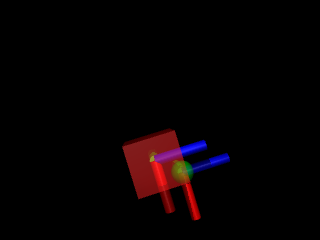

In [20]:
# additional rendering options 
# enable transparency and frames visualization

scene_option = mujoco.wrapper.core.MjvOption()
scene_option.frame = enums.mjtFrame.mjFRAME_GEOM
scene_option.flags[enums.mjtVisFlag.mjVIS_TRANSPARENT] = True
pixels = physics.render(scene_option=scene_option)
PIL.Image.fromarray(pixels)

In [21]:
# making  a video for transparency and frames visualization

duration = 10 # seconds
framerate = 30 # Hz

frames = []
physics.reset()
while physics.data.time < duration:
    physics.step()
    
    if len(frames) < physics.data.time * framerate:
        pixels = physics.render(scene_option = scene_option)
        frames.append(pixels)
display_video(frames, framerate)

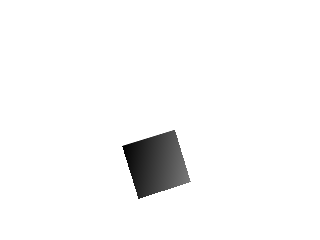

In [22]:
# Depth rendering

# depth is a float array, in meters
depth = physics.render(depth=True)
# shift nearest values to the origin
depth -= depth.min()
#scale by mean distance of near rays
depth /= 2*depth[depth <= 1].mean()
# scale to [0, 255]
pixels = 255*np.clip(depth, 0, 1)
PIL.Image.fromarray(pixels.astype(np.uint8))

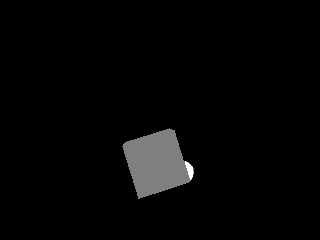

In [23]:
# Segmentation rendering

seg = physics.render(segmentation=True)

geom_ids = seg[:, :, 0]
# infinity is mapped to -1
geom_ids = geom_ids.astype(np.float64) + 1
# scale to [0, 1]
geom_ids = geom_ids / geom_ids.max()
pixels = 255 * geom_ids
PIL.Image.fromarray(pixels.astype(np.uint8))

In [24]:
# mujoco basics and named indexing

# mjModel

physics.model.geom_pos

array([[0. , 0. , 0. ],
       [0.2, 0.2, 0.2]])

In [25]:
help(type(physics.model).geom_pos)

Help on CachedProperty in module dm_control.mujoco.wrapper.util:

    local position offset rel. to body (ngeom x 3).



In [26]:
# The model.opt structure contains global quantities like
print('timestep = ', physics.model.opt.timestep)
print('gravity = ', physics.model.opt.gravity)

timestep =  0.002
gravity =  [ 0.    0.   -9.81]


In [27]:
# mjData
# mjData, encapsulated in physics.data, contains the state and quantities that depend on it. 
#The state is made up of time, generalized positions and generalised velocities. 
#These are respectively data.time, data.qpos and data.qvel.

print('time = ', physics.data.time, 'position = ', physics.data.qpos, 'velocity = ', physics.data.qvel )

time =  10.000000000000009 position =  [-1.41079857] velocity =  [-7.44532352]


In [28]:
print(physics.data.geom_xpos)

[[-0.03896141 -0.01043968 -0.44736694]
 [ 0.19528227  0.05232573 -0.69473389]]


In [29]:
# Named indexing

physics.named.model.geom_pos

FieldIndexer(geom_pos):
                 x         y         z         
0      red_box [ 0         0         0       ]
1 green_sphere [ 0.2       0.2       0.2     ]

In [30]:
physics.named.data.geom_xpos

FieldIndexer(geom_xpos):
                 x         y         z         
0      red_box [-0.039    -0.0104   -0.447   ]
1 green_sphere [ 0.195     0.0523   -0.695   ]

In [31]:
physics.named.data.geom_xpos['green_sphere', 'z']

-0.6947338895059701

In [32]:
physics.named.data.geom_xpos['red_box', 'z']

-0.4473669447529851

In [33]:
physics.named.data.qpos['swing']

array([-1.41079857])

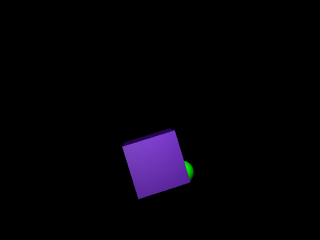

In [34]:
# changing colors using named indexing

random_rgb = np.random.rand(3)
physics.named.model.geom_rgba['red_box', :3] = random_rgb
pixels = physics.render()
PIL.Image.fromarray(pixels)

In [35]:
#Setting the state with reset_context()

physics.named.data.qpos['swing'] = np.pi
print('withoud reset_context, spatial positions are not updated', 
     physics.named.data.geom_xpos['green_sphere', ['z']])

with physics.reset_context():
    physics.named.data.qpos['swing'] = np.pi-1.555648  
    
print('after reset_context, positions are updeted:', physics.named.data.geom_xpos['green_sphere', ['z']] )

withoud reset_context, spatial positions are not updated [-0.69473389]
after reset_context, positions are updeted: [0.35956142]


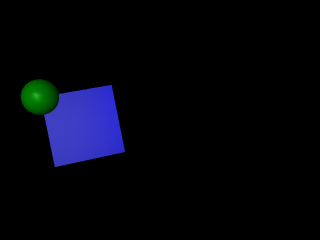

In [36]:
random_rgb = [0, 0, 1]
physics.named.model.geom_rgba['red_box', :3] = random_rgb
pixels = physics.render()
PIL.Image.fromarray(pixels)

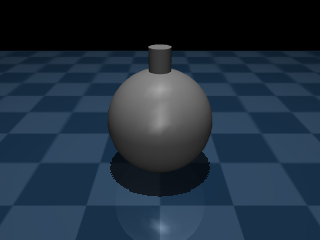

In [37]:
# Free bodies: the self-inverting "tippe-top"

tippe_top = """
<mujoco model="tippe top">
    <option integrator="RK4"/>
    <asset>
        <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3" 
        rgb2=".2 .3 .4" width="300" height="300"/>
        <material name="grid" texture="grid" texrepeat="8 8" reflectance=".2" />
    </asset>
    <worldbody>
        <geom size=".2 .2 .01" type="plane" material="grid"/>
        <light pos="0 0 .6"/>
        <camera name="closeup" pos="0 -.1 .07" xyaxes="1 0 0 0 1 2"/>
        <body name="top" pos="0 0 .02">
            <freejoint/>
            <geom name="ball" type="sphere" size=".02"/>
            <geom name="stem" type="cylinder" pos="0 0 .02" size="0.004 .008"/>
            <geom name="ballast" type="box" size=".023 .023 0.005" pos="0 0 -.015" 
            contype="0" conaffinity="0" group="3"/>
        </body>    
    
    </worldbody>
    <keyframe>
        <key name="spinning" qpos="0 0 0.02 1 0 0 0" qvel="0 0 0 0 1 200"/>
    </keyframe>
</mujoco>
"""

physics = mujoco.Physics.from_xml_string(tippe_top)
PIL.Image.fromarray(physics.render(camera_id='closeup'))

In [38]:
print('positions = ', physics.data.qpos)
print('velocities = ', physics.data.qvel)

positions =  [0.   0.   0.02 1.   0.   0.   0.  ]
velocities =  [0. 0. 0. 0. 0. 0.]


In [39]:
# write video for the tipple-top

duration = 20
framerate = 60 

# Simulate and display video

frames = []
physics.reset(0) # reset to keyframe 0 (load a saved state)
while physics.data.time < duration:
    physics.step()
    if len(frames) < (physics.data.time) *  framerate:
        pixels = physics.render(camera_id='closeup')
        frames.append(pixels)
display_video(frames, framerate)

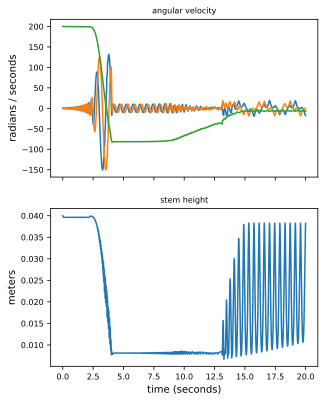

In [40]:
# Measuring values from physics.data

timevals = []
angular_velocity = []
stem_height = []

# Simulate and save data
physics.reset(0)
while physics.data.time < duration:
    physics.step()
    timevals.append(physics.data.time)
    angular_velocity.append(physics.data.qvel[3:6].copy())
    stem_height.append(physics.named.data.geom_xpos['stem', 'z'])
    
dpi = 100
width = 480
height = 640
figsize = (width / dpi, height / dpi)
_, ax = plt.subplots(2, 1, figsize=figsize, dpi=dpi, sharex=True)

ax[0].plot(timevals, angular_velocity)
ax[0].set_title('angular velocity')
ax[0].set_ylabel('radians / seconds')

ax[1].plot(timevals, stem_height)
ax[1].set_xlabel('time (seconds)')
ax[1].set_ylabel('meters')
_ = ax[1].set_title('stem height')

In [41]:
class Leg(object):
    """A 2-DoF Leg with position actuators"""
    def __init__(self, length, rgba):
        self.model = mjcf.RootElement()
        
        # Defaults
        self.model.default.joint.damping = 2
        self.model.default.joint.type = 'hinge'
        self.model.default.geom.type = 'capsule'
        self.model.default.geom.rgba = rgba
        
        # Thigh  
        self.thigh = self.model.worldbody.add('body')
        self.hip = self.thigh.add('joint', axis=[0, 0, 1])
        self.thigh.add('geom', fromto=[0, 0, 0, length, 0, 0], size=[length/4])
        
        # Hip
        self.shin = self.thigh.add('body', pos=[length, 0, 0])
        self.knee = self.shin.add('joint', axis=[0, 1, 0])
        self.shin.add('geom', fromto=[0, 0, 0, 0, 0, -length], size=[length/5])
        
        # Position actiators
        self.model.actuator.add('position', joint=self.hip, kp=10)
        self.model.actuator.add('position', joint=self.knee, kp=10)
        

In [42]:
BODY_RADIUS = 0.1
BODY_SIZE = (BODY_RADIUS, BODY_RADIUS, BODY_RADIUS / 2)
random_state = np.random.RandomState(42)

def make_creature(num_legs):
    # constructs a creature with 'num_legs' legs
    rgba = random_state.uniform([0, 0, 0, 1], [1, 1, 1, 1])
    model = mjcf.RootElement()
    model.compiler.angle = 'radian'  #use radians
    
    
    # Make the torso geom
    model.worldbody.add('geom', name='torso', type='ellipsoid', size=BODY_SIZE, rgba=rgba)
    
    for i in range(num_legs):
        theta = 2 * i * np.pi / num_legs
        hip_pos = BODY_RADIUS * np.array([np.cos(theta), np.sin(theta), 0])
        hip_site = model.worldbody.add('site', pos=hip_pos, euler=[0, 0, theta])
        leg = Leg(length=BODY_RADIUS, rgba=rgba)
        hip_site.attach(leg.model)
    return model
    

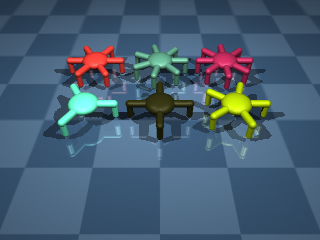

In [43]:
# Six Creatures on a floor
arena = mjcf.RootElement()
chequered = arena.asset.add('texture', type='2d', builtin='checker', 
                           width=300, height=300, rgb1=[.2, .3, .4], rgb2=[.3, .4, .5])
grid = arena.asset.add('material', name='grid', texture=chequered, texrepeat=[5, 5], reflectance=.2)
arena.worldbody.add('geom', type='plane', size=[2, 2, .1], material=grid)
for x in [-2, 2]:
    arena.worldbody.add('light', pos=[x, -1, 3], dir=[-x, 1, -2])
    
# instantiate 6 creatures with 3 to 8 legs
creatures = [make_creature(num_legs=num_legs) for num_legs in range(3, 9)]

# place them on a grid in the camera
height = .15
grid = 5 * BODY_RADIUS
xpos, ypos, zpos = np.meshgrid([-grid, 0, grid], [0, grid], [height])
for i, model in enumerate(creatures):
    # place spawn sites on a grid
    spawn_pos = (xpos.flat[i], ypos.flat[i], zpos.flat[i])
    spawn_site = arena.worldbody.add('site', pos=spawn_pos, group=3)
    # attach to the arena at the spawn sites, with a free joint
    spawn_site.attach(model).add('freejoint')

physics = mjcf.Physics.from_mjcf_model(arena)
PIL.Image.fromarray(physics.render())

In [44]:
duration = 20   # (Seconds)
framerate = 30  # (Hz)
video = []
pos_x = []
pos_y = []
torsos = []  # List of torso geom elements.
actuators = []  # List of actuator elements.
for creature in creatures:
  torsos.append(creature.find('geom', 'torso'))
  actuators.extend(creature.find_all('actuator'))

# Control signal frequency, phase, amplitude.
freq = 5
phase = 2 * np.pi * random_state.rand(len(actuators))
amp = 0.9

# Simulate, saving video frames and torso locations.
physics.reset()
while physics.data.time < duration:
  # Inject controls and step the physics.
  physics.bind(actuators).ctrl = amp * np.sin(freq * physics.data.time + phase)
  physics.step()

  # Save torso horizontal positions using bind().
  pos_x.append(physics.bind(torsos).xpos[:, 0].copy())
  pos_y.append(physics.bind(torsos).xpos[:, 1].copy())

  # Save video frames.
  if len(video) < physics.data.time * framerate:
    pixels = physics.render()
    video.append(pixels.copy())

display_video(video, framerate)

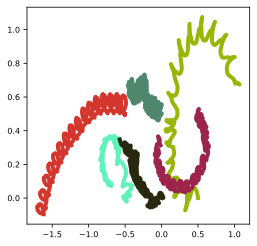

In [45]:
# movement trajectories

creature_colors = physics.bind(torsos).rgba[:, :3]
fig, ax = plt.subplots(figsize=(4,4))
ax.set_prop_cycle(color=creature_colors)
_ = ax.plot(pos_x, pos_y, linewidth=4)

In [46]:
# Composer tutoria

class Creature(composer.Entity):
  """A multi-legged creature derived from `composer.Entity`."""
  def _build(self, num_legs):
    self._model = make_creature(num_legs)

  def _build_observables(self):
    return CreatureObservables(self)

  @property
  def mjcf_model(self):
    return self._model

  @property
  def actuators(self):
    return tuple(self._model.find_all('actuator'))


# Add simple observable features for joint angles and velocities.
class CreatureObservables(composer.Observables):

  @composer.observable
  def joint_positions(self):
    all_joints = self._entity.mjcf_model.find_all('joint')
    return observable.MJCFFeature('qpos', all_joints)

  @composer.observable
  def joint_velocities(self):
    all_joints = self._entity.mjcf_model.find_all('joint')
    return observable.MJCFFeature('qvel', all_joints)

In [47]:
NUM_SUBSTEPS = 25  # The number of physics substeps per control timestep.


class Button(composer.Entity):
  """A button Entity which changes colour when pressed with certain force."""
  def _build(self, target_force_range=(5, 10)):
    self._min_force, self._max_force = target_force_range
    self._mjcf_model = mjcf.RootElement()
    self._geom = self._mjcf_model.worldbody.add(
        'geom', type='cylinder', size=[0.25, 0.02], rgba=[1, 0, 0, 1])
    self._site = self._mjcf_model.worldbody.add(
        'site', type='cylinder', size=self._geom.size*1.01, rgba=[1, 0, 0, 0])
    self._sensor = self._mjcf_model.sensor.add('touch', site=self._site)
    self._num_activated_steps = 0

  def _build_observables(self):
    return ButtonObservables(self)

  @property
  def mjcf_model(self):
    return self._mjcf_model
  # Update the activation (and colour) if the desired force is applied.
  def _update_activation(self, physics):
    current_force = physics.bind(self.touch_sensor).sensordata[0]
    self._is_activated = (current_force >= self._min_force and
                          current_force <= self._max_force)
    physics.bind(self._geom).rgba = (
        [0, 1, 0, 1] if self._is_activated else [1, 0, 0, 1])
    self._num_activated_steps += int(self._is_activated)

  def initialize_episode(self, physics, random_state):
    self._reward = 0.0
    self._num_activated_steps = 0
    self._update_activation(physics)

  def after_substep(self, physics, random_state):
    self._update_activation(physics)

  @property
  def touch_sensor(self):
    return self._sensor

  @property
  def num_activated_steps(self):
    return self._num_activated_steps


class ButtonObservables(composer.Observables):
  """A touch sensor which averages contact force over physics substeps."""
  @composer.observable
  def touch_force(self):
    return observable.MJCFFeature('sensordata', self._entity.touch_sensor,
                                  buffer_size=NUM_SUBSTEPS, aggregator='mean')

In [48]:
class UniformCircle(variation.Variation):
  """A uniformly sampled horizontal point on a circle of radius `distance`."""
  def __init__(self, distance):
    self._distance = distance
    self._heading = distributions.Uniform(0, 2*np.pi)

  def __call__(self, initial_value=None, current_value=None, random_state=None):
    distance, heading = variation.evaluate(
        (self._distance, self._heading), random_state=random_state)
    return (distance*np.cos(heading), distance*np.sin(heading), 0)

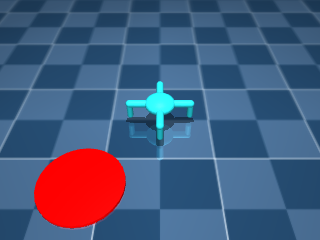

In [49]:
class PressWithSpecificForce(composer.Task):

  def __init__(self, creature):
    self._creature = creature
    self._arena = floors.Floor()
    self._arena.add_free_entity(self._creature)
    self._arena.mjcf_model.worldbody.add('light', pos=(0, 0, 4))
    self._button = Button()
    self._arena.attach(self._button)

    # Configure initial poses
    self._creature_initial_pose = (0, 0, 0.15)
    button_distance = distributions.Uniform(0.5, .75)
    self._button_initial_pose = UniformCircle(button_distance)

    # Configure variators
    self._mjcf_variator = variation.MJCFVariator()
    self._physics_variator = variation.PhysicsVariator()

    # Configure and enable observables
    pos_corrptor = noises.Additive(distributions.Normal(scale=0.01))
    self._creature.observables.joint_positions.corruptor = pos_corrptor
    self._creature.observables.joint_positions.enabled = True
    vel_corruptor = noises.Multiplicative(distributions.LogNormal(sigma=0.01))
    self._creature.observables.joint_velocities.corruptor = vel_corruptor
    self._creature.observables.joint_velocities.enabled = True
    self._button.observables.touch_force.enabled = True

    def to_button(physics):
      button_pos, _ = self._button.get_pose(physics)
      return self._creature.global_vector_to_local_frame(physics, button_pos)

    self._task_observables = {}
    self._task_observables['button_position'] = observable.Generic(to_button)

    for obs in self._task_observables.values():
      obs.enabled = True

    self.control_timestep = NUM_SUBSTEPS * self.physics_timestep

  @property
  def root_entity(self):
    return self._arena

  @property
  def task_observables(self):
    return self._task_observables

  def initialize_episode_mjcf(self, random_state):
    self._mjcf_variator.apply_variations(random_state)

  def initialize_episode(self, physics, random_state):
    self._physics_variator.apply_variations(physics, random_state)
    creature_pose, button_pose = variation.evaluate(
        (self._creature_initial_pose, self._button_initial_pose),
        random_state=random_state)
    self._creature.set_pose(physics, position=creature_pose)
    self._button.set_pose(physics, position=button_pose)

  def get_reward(self, physics):
    return self._button.num_activated_steps / NUM_SUBSTEPS
creature = Creature(num_legs=4)
task = PressWithSpecificForce(creature)
env = composer.Environment(task, random_state=np.random.RandomState(42))

env.reset()
PIL.Image.fromarray(env.physics.render())

In [50]:
#The Control Suite

# iterationg over tasks

max_len = max(len(d) for d, _ in suite.BENCHMARKING)
for domain, task in suite.BENCHMARKING:
    print(f'{domain:<{max_len}} {task}')

acrobot     swingup
acrobot     swingup_sparse
ball_in_cup catch
cartpole    balance
cartpole    balance_sparse
cartpole    swingup
cartpole    swingup_sparse
cheetah     run
finger      spin
finger      turn_easy
finger      turn_hard
fish        upright
fish        swim
hopper      stand
hopper      hop
humanoid    stand
humanoid    walk
humanoid    run
manipulator bring_ball
pendulum    swingup
point_mass  easy
reacher     easy
reacher     hard
swimmer     swimmer6
swimmer     swimmer15
walker      stand
walker      walk
walker      run


In [52]:
# loading and simulating a 'suite'
# load the environment

random_state = np.random.RandomState(42)
env = suite.load('hopper', 'hop', task_kwargs={'random': random_state})

# Simulate episode with random actions

duration = 15 #seconds
frames = []
ticks = []
rewards = []
observations = []

spec = env.action_spec()
time_step = env.reset()

while env.physics.data.time < duration:
    
    action = random_state.uniform(spec.minimum, spec.maximum, spec.shape)
    time_step = env.step(action)
    
    camera0 = env.physics.render(camera_id=0, height=200, width=200)
    camera1 = env.physics.render(camera_id=1, height=200, width=200)
    frames.append(np.hstack((camera0, camera1)))
    rewards.append(time_step.reward)
    observations.append(copy.deepcopy(time_step.observation))
    ticks.append(env.physics.data.time)
    
html_video = display_video(frames, framerate=1./env.control_timestep())

In [53]:
html_video

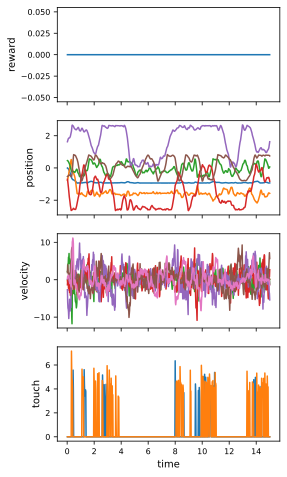

In [60]:
num_sensors = len(time_step.observation)

_, ax = plt.subplots(1 + num_sensors, 1, sharex=True, figsize=(4, 8))
ax[0].plot(ticks, rewards)
ax[0].set_ylabel('reward')
ax[-1].set_xlabel('time')

for i, key in enumerate(time_step.observation):
    data = np.asarray([observations[j][key] for j in range(len(observations))])
    ax[i+1].plot(ticks, data, label=key)
    ax[i+1].set_ylabel(key)

Iterating over all 19 domains in the Suite:
acrobot swingup_sparse
ball_in_cup catch
cartpole three_poles
cheetah run
dog fetch
finger turn_hard
fish swim
hopper hop
humanoid run_pure_state
humanoid_CMU run
lqr lqr_6_2
manipulator insert_peg
pendulum swingup
point_mass hard
quadruped fetch
reacher hard
stacker stack_4
swimmer swimmer15
walker run


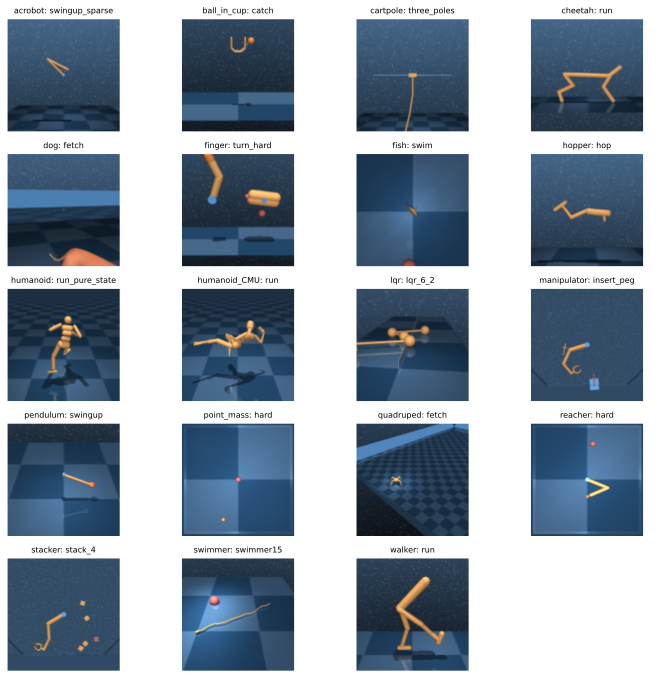

In [65]:
# Visualizing an initial state of one task per domain in the Control Suite

domains_tasks = {domain: task for domain, task in suite.ALL_TASKS}
random_state = np.random.RandomState(42)
num_domains = len(domains_tasks)
n_col = num_domains // int(np.sqrt(num_domains))
n_row = num_domains // n_col + int(0 < num_domains % n_col)
_, ax = plt.subplots(n_row, n_col, figsize=(12, 12))
for a in ax.flat:
  a.axis('off')
  a.grid(False)

print(f'Iterating over all {num_domains} domains in the Suite:')
for j, [domain, task] in enumerate(domains_tasks.items()):
  print(domain, task)

  env = suite.load(domain, task, task_kwargs={'random': random_state})
  timestep = env.reset()
  pixels = env.physics.render(height=200, width=200, camera_id=0)

  ax.flat[j].imshow(pixels)
  ax.flat[j].set_title(domain + ': ' + task)



In [66]:
# Locomotion
# Humanoid running along corridor with obstacles
# A position controlled `cmu_humanoid`

walker = cmu_humanoid.CMUHumanoidPositionControlledV2020(
    observable_options={'egocentric_camera': dict(enabled=True)})

In [67]:
#A corridor arena with wall obstacles

arena = corridor_arenas.WallsCorridor(
    wall_gap=3.,
    wall_width=distributions.Uniform(2., 3.),
    wall_height=distributions.Uniform(2.5, 3.5),
    corridor_width=4.,
    corridor_length=30.,
)

In [68]:
# A task to navigate the arena

task = corridor_tasks.RunThroughCorridor(
    walker=walker,
    arena=arena,
    walker_spawn_position=(0.5, 0, 0),
    target_velocity=3.0,
    physics_timestep=0.005,
    control_timestep=0.03,
)

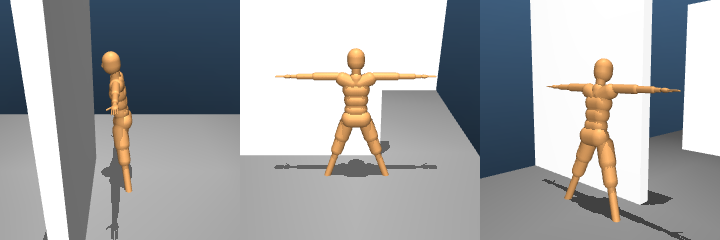

In [69]:
#The `RunThroughCorridor` environment
env = composer.Environment(
    task=task,
    time_limit=10,
    random_state=np.random.RandomState(42),
    strip_singleton_obs_buffer_dim=True,
)
env.reset()
pixels = []
for camera_id in range(3):
  pixels.append(env.physics.render(camera_id=camera_id, width=240))
PIL.Image.fromarray(np.hstack(pixels))

In [78]:
duration = 5    # (seconds)
framerate = 120  # (Hz)

# Simulate and display video.
frames = []
env.reset()  # Reset to keyframe 0 (load a saved state).
while env.physics.data.time < duration:
  env.physics.step()
  if len(frames) < (env.physics.data.time) * framerate:
    for camera_id in range(3):
      pixel = env.physics.render(camera_id=camera_id, width=240)
    
    frames.append(pixel)

display_video(frames, framerate)

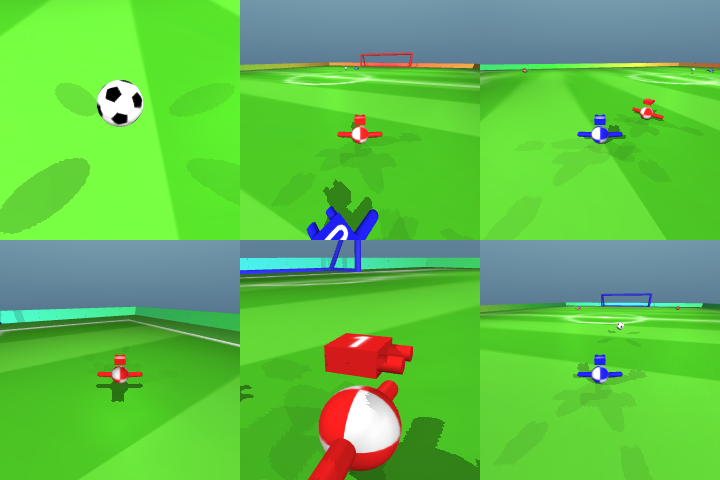

In [79]:
# Multi-Agent Soccer

random_state = np.random.RandomState(42)
env = soccer.load(
    team_size=2,
    time_limit=45.,
    random_state=random_state,
    disable_walker_contacts=False,
    walker_type=soccer.WalkerType.BOXHEAD,
)
env.reset()
pixels = []
# Select a random subset of 6 cameras (soccer envs have lots of cameras)
cameras = random_state.choice(env.physics.model.ncam, 6, replace=False)
for camera_id in cameras:
  pixels.append(env.physics.render(camera_id=camera_id, width=240))
image = np.vstack((np.hstack(pixels[:3]), np.hstack(pixels[3:])))
PIL.Image.fromarray(image)

In [84]:
duration = 5    # (seconds)
framerate = 120  # (Hz)

# Simulate and display video.
frames = []

env.reset()  # Reset to keyframe 0 (load a saved state).

while env.physics.data.time < duration:
  
  env.physics.step()
  if len(frames) < (env.physics.data.time) * framerate:
    for camera_id in range(3):
      pixel = env.physics.render(camera_id=camera_id, width=240)
    
    frames.append(pixel)

display_video(frames, framerate)

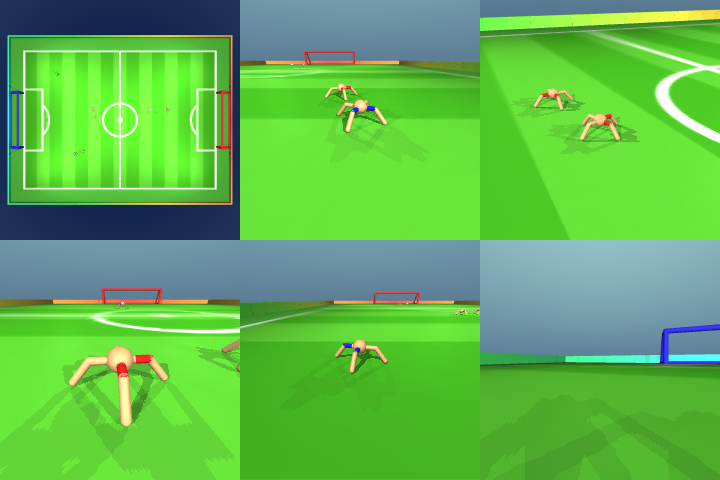

In [104]:
random_state = np.random.RandomState(42)
env = soccer.load(
    team_size=3,
    time_limit=45.,
    random_state=random_state,
    disable_walker_contacts=False,
    walker_type=soccer.WalkerType.ANT,
)
env.reset()

pixels = []
cameras = random_state.choice(env.physics.model.ncam, 6, replace=False)
for camera_id in cameras:
  pixels.append(env.physics.render(camera_id=camera_id, width=240))
image = np.vstack((np.hstack(pixels[:3]), np.hstack(pixels[3:])))
PIL.Image.fromarray(image)

In [106]:
duration = 5    # (seconds)
framerate = 120  # (Hz)

# Simulate and display video.
frames = []

env.reset()  # Reset to keyframe 0 (load a saved state).

while env.physics.data.time < duration:
  
  env.physics.step()
  if len(frames) < (env.physics.data.time) * framerate:
    for camera_id in range(3):
      pixel = env.physics.render(camera_id=camera_id, width=240)
    
    frames.append(pixel)

display_video(frames, framerate)

In [107]:
# Manipulation
# Listing all `manipulation` tasks
# `ALL` is a tuple containing the names of all of the environments in the suite.
print('\n'.join(manipulation.ALL))

stack_2_bricks_features
stack_2_bricks_vision
stack_2_bricks_moveable_base_features
stack_2_bricks_moveable_base_vision
stack_3_bricks_features
stack_3_bricks_vision
stack_3_bricks_random_order_features
stack_2_of_3_bricks_random_order_features
stack_2_of_3_bricks_random_order_vision
reassemble_3_bricks_fixed_order_features
reassemble_3_bricks_fixed_order_vision
reassemble_5_bricks_random_order_features
reassemble_5_bricks_random_order_vision
lift_brick_features
lift_brick_vision
lift_large_box_features
lift_large_box_vision
place_brick_features
place_brick_vision
place_cradle_features
place_cradle_vision
reach_duplo_features
reach_duplo_vision
reach_site_features
reach_site_vision


In [108]:
#Listing `manipulation` tasks that use vision
print('\n'.join(manipulation.get_environments_by_tag('vision')))

stack_2_bricks_vision
stack_2_bricks_moveable_base_vision
stack_3_bricks_vision
stack_2_of_3_bricks_random_order_vision
reassemble_3_bricks_fixed_order_vision
reassemble_5_bricks_random_order_vision
lift_brick_vision
lift_large_box_vision
place_brick_vision
place_cradle_vision
reach_duplo_vision
reach_site_vision


In [110]:
# Loading and simulating a `manipulation` task
# test {"timeout": 180}

duration = 5   # (seconds)
framerate = 120  # (Hz)

env = manipulation.load('stack_2_of_3_bricks_random_order_vision', seed=42)
action_spec = env.action_spec()

def sample_random_action():
  return env.random_state.uniform(
      low=action_spec.minimum,
      high=action_spec.maximum,
  ).astype(action_spec.dtype, copy=False)

# Step the environment through a full episode using random actions and record
# the camera observations.
frames = []
timestep = env.reset()
frames.append(timestep.observation['front_close'])

while env.physics.data.time < duration:
    timestep = env.step(sample_random_action())
    if len(frames) < (env.physics.data.time) * framerate:
        pixels = timestep.observation['front_close']
    frames.append(pixels)
all_frames = np.concatenate(frames, axis=0)
display_video(all_frames, 60)